In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
from historical_data import get_historical_prices_for_two_assets
from datetime import datetime

stable_coin_symbol = "USDT"
A_symbol = "ETH"
B_symbol = "BTC"
interval = "5m"

start_time = datetime(2024, 11, 1, 12, 0, 0)
end_time = datetime(2024, 11, 10, 12, 0, 0)
historical_prices = get_historical_prices_for_two_assets(
    stable_coin_symbol, A_symbol, B_symbol, interval, start_time, end_time
)

historical_prices

A symbol candles count: 2593
B symbol candles count: 2593
Joined candles count: 2593


,time,price_A,price_B
0,2024-11-01 11:00:00,2518.75,69989.64
1,2024-11-01 11:05:00,2522.41,70150.00
2,2024-11-01 11:10:00,2520.49,70056.00
3,2024-11-01 11:15:00,2522.80,70176.00
4,2024-11-01 11:20:00,2521.52,70118.02
...,...,...,...
2588,2024-11-10 10:40:00,3191.52,79430.00
2589,2024-11-10 10:45:00,3195.74,79451.30
2590,2024-11-10 10:50:00,3200.80,79552.03
2591,2024-11-10 10:55:00,3203.40,79544.00


In [3]:
from user.informed_user import InformedUser
from user.uninformed_user import UninformedUser
from simulation.simulation import Simulation

informed_user = InformedUser()
uninformed_user = UninformedUser()

In [4]:
def get_initial_pool_sizes(price_A: float, price_B: float, total_pool: float) -> tuple:
    '''
    Returns the initial pool sizes for the two assets given the prices of the two assets
    '''
    r = price_A / price_B
    q_A = total_pool / (r + 1)
    q_B = total_pool - q_A
    return q_A, q_B

initial_quantity_A, initial_quantity_B = get_initial_pool_sizes(
    historical_prices["price_A"].iloc[0], historical_prices["price_B"].iloc[0], 100000
)

print(f"Initial quantity of A: {initial_quantity_A}, Initial quantity of B: {initial_quantity_B}")

Initial quantity of A: 96526.26406406211, Initial quantity of B: 3473.7359359378897


In [5]:
from pool.simple_pool import SimplePool
from pool.abstract_pool import PoolLiquidityState

pool = SimplePool(
    liquidity_state=PoolLiquidityState(
        quantity_a=initial_quantity_A,
        quantity_b=initial_quantity_B
    ),
    alpha=0.1,
)

In [6]:
import numpy as np

np.random.seed(0)

simulation = Simulation(
    pool=pool,
    network_fee=0,
)

simulation_result = simulation.simulate(
    p_UU=0.5,
    informed_user=informed_user,
    uninformed_user=uninformed_user,
    prices=historical_prices,
)

In [7]:
simulation_result.snapshots[-1]

SimulationState(user_states={<UserType.INFORMED: 1>: ParticipantState(total_markout=np.float64(265773.43313007336), position=Position(position_a=np.float64(4291.667792687132), position_b=np.float64(-163.94340002115058)), valuation=np.float64(694314.6916705146)), <UserType.UNINFORMED: 2>: ParticipantState(total_markout=np.float64(-33322.252274306615), position=Position(position_a=np.float64(939.3916819055511), position_b=np.float64(-35.095742961583916)), valuation=np.float64(214765.30088027194))}, lp_state=ParticipantState(total_markout=np.float64(-232451.18085576655), position=Position(position_a=np.float64(91295.2045894695), position_b=np.float64(3672.775078920616)), valuation=np.float64(584304588.7501965)), lp_with_just_hold_strategy=ParticipantState(total_markout=0, position=Position(position_a=np.float64(96526.26406406211), position_b=np.float64(3473.7359359378897)), valuation=np.float64(585213668.7427478)))

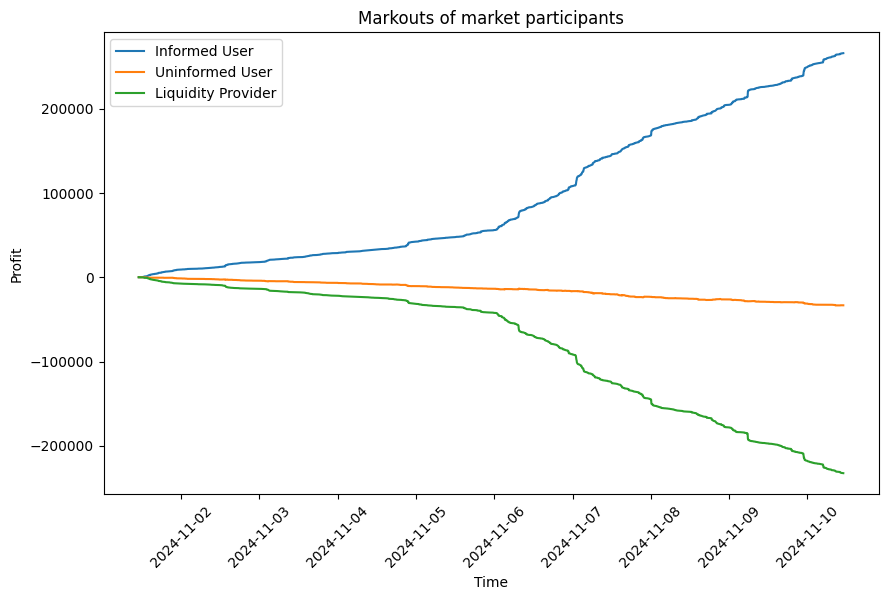

In [8]:
# Plot all participants' profits
import seaborn as sns
import matplotlib.pyplot as plt
from simulation.simulation import UserType, SimulationResult

fig, ax = plt.subplots(figsize=(10, 6))

def extract_user_markouts(
    simulation_result: SimulationResult, user_type: UserType
) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.user_states[user_type].total_markout)
    return res
        
def extract_lp_markouts(simulation_result: SimulationResult) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.lp_state.total_markout)
    return res

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_user_markouts(simulation_result, UserType.INFORMED),
    ax=ax,
    label="Informed User",
)

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_user_markouts(simulation_result, UserType.UNINFORMED),
    ax=ax,
    label="Uninformed User",
)


sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_lp_markouts(simulation_result),
    ax=ax,
    label="Liquidity Provider",
)

plt.xlabel("Time")
plt.ylabel("Profit")

plt.xticks(rotation=45)

plt.title("Markouts of market participants")

plt.show()

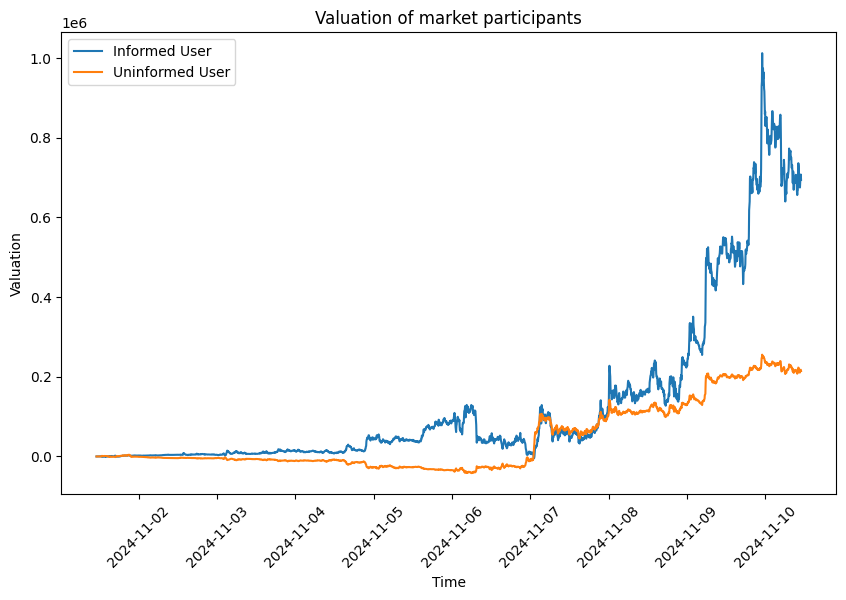

In [9]:
def extract_user_valuations(
    simulation_result: SimulationResult, user_type: UserType
) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.user_states[user_type].valuation)
    return res
        

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_user_valuations(simulation_result, UserType.INFORMED),
    ax=ax,
    label="Informed User",
)

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_user_valuations(simulation_result, UserType.UNINFORMED),
    ax=ax,
    label="Uninformed User",
)

plt.xlabel("Time")
plt.ylabel("Valuation")


plt.xticks(rotation=45)

plt.title("Valuation of market participants")

plt.show()

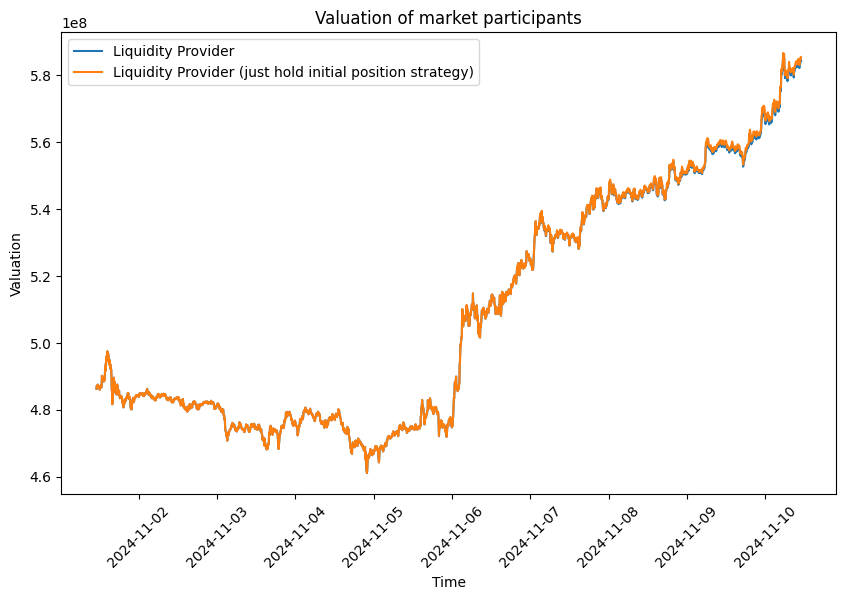

In [10]:
def extract_lp_valuations(
    simulation_result: SimulationResult
) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.lp_state.valuation)
    return res

def extract_lp_only_hold_valuations(
    simulation_result: SimulationResult
) -> list:
    res = []
    for snapshot in simulation_result.snapshots:
        res.append(snapshot.lp_with_just_hold_strategy.valuation)
    return res

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_lp_valuations(simulation_result),
    ax=ax,
    label="Liquidity Provider",
)

sns.lineplot(
    x=simulation_result.timestamps,
    y=extract_lp_only_hold_valuations(simulation_result),
    ax=ax,
    label="Liquidity Provider (just hold initial position strategy)",
)

plt.xlabel("Time")
plt.ylabel("Valuation")

plt.xticks(rotation=45)

plt.title("Valuation of market participants")

plt.show()

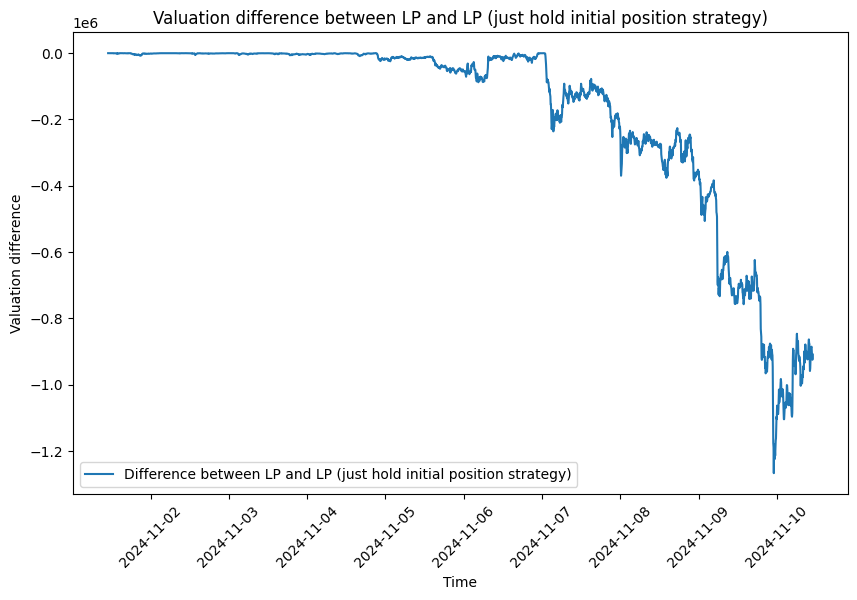

In [11]:
# Plot difference between two lp strategies

lp_valuations_diff = np.array(extract_lp_valuations(simulation_result)) - np.array(extract_lp_only_hold_valuations(simulation_result))

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    x=simulation_result.timestamps,
    y=lp_valuations_diff,
    ax=ax,
    label="Difference between LP and LP (just hold initial position strategy)",
)

plt.xlabel("Time")
plt.ylabel("Valuation difference")

plt.xticks(rotation=45)

plt.title("Valuation difference between LP and LP (just hold initial position strategy)")

plt.show()